# Pronósticos de Series de Tiempo - Parte 3: Prophet

## 1. Introducción

En la [parte 1](https://gonzalezhomar.netlify.app/post/pronostico_1_manual/) presente el problema de hacer pronósticos para los principales impuestos de México, abordando el tema desde una metodología "a la vieja escuela". En la [parte 2](https://gonzalezhomar.netlify.app/post/pronostico_2_autoarima/) abordé el mismo problema a través de una *notebook* con las librerias statsmodels y *pmdarima*, que desde mi perspectiva representan una mejora del modelo manual por su simplicidad, aunque en el fondo ambos son modelos ARIMA. En esta [parte 3](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/) se hará el mismo ejercicio, utilizando la herramienta Prophet desarrollada por Facebook.

Daré por sentado la construcción de la base de datos y buena parte del análisis estadístico que ya realicé en la parte 1, por lo que me citaré a mi mismo cuando así lo consideré... yo mismo... jeje. En este caso, leí sobre Prophet en [esta publicación de Medium](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3), y la probe exitosamente con anterioridad, por lo que para mí, se convirtió en una alternativa a los tradicionales modelos ARIMA. La *notebook* con el código completo de esta publicación se puede encontrar en mi repositorio de [Github](https://github.com/gonzalezhomar/articulos_pronosticos) o la pueden ver directamente [aquí](https://nbviewer.jupyter.org/github/gonzalezhomar/articulos_pronosticos/blob/main/Pronostico_3.ipynb).

## 2. ¿Qué es Prophet?

De acuerdo a su misma página, [Prophet](https://facebook.github.io/prophet/) "es un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de las vacaciones. Funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es robusto ante los datos faltantes y los cambios en la tendencia, y por lo general maneja bien los valores atípicos."

Con esta herramienta, el equipo de ciencia de datos de Facebook buscaba lograr los siguientes objetivos:
- Lograr modelos de pronóstico rápidoz y precisos.
- Obtener pronósticos razonablemente correctos de manera automática.
- No obstante el punto anterior, los resultados pueden ser adecuados manualmente.
- Librería disponible tanto en Python, como en R.

A diferencia de los modelos ARIMA que trabajan con una descomposición en 3 partes, [tendencia, componente estacional y error](https://en.wikipedia.org/wiki/X-13ARIMA-SEATS), Prophet utiliza una descomposición adicional, esto es en 4 partes [tendencia, componente estacional, días feriados y error](https://peerj.com/preprints/3190/). Esto porque Prophet está diseñado para trabajar con datos diarios, y considera está serie en lo individal para aislar sus efectos. 

Una de las grandes ventajas es que Prophet realiza todo de manera automática, incluso considerando quiebres estructurales. No obstante, Prophet se puede ajustar manualmente para lo cual leí [la documentación de Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) e introduje los cambios que consideré necesarios.

En comparación con el trabajo que hice en la [parte 2](https://gonzalezhomar.netlify.app/post/pronostico_2_autoarima/), los pronósticos con Prophet requieren menos código, por lo que son más fáciles de implementar y requieren menor interacción. Tomando como base el análisis hecho en la [parte 1](https://gonzalezhomar.netlify.app/post/pronostico_1_manual/), para el Impuesto al Valor Agregado (IVA) y para el Impuesto Sobre la Renta (ISR), utilizaré como variable explícativa el PIB y una dummy con la tasa del IVA y la reforma del ISR, respectivamente. En el resto de las series, haré el análisis de manera mensual. 

Aquí mi carga de paqueterías:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
from fbprophet.plot import add_changepoints_to_plot

## 3. Análisis de las Series Trimestrales

Nota. Solo dejaré comentarios para la serie de ISR. Para el IVA dejo el análisis sin comentarios.

### 3.1 Impuesto Sobre la Renta, ISR

Para utilizar Prophet, los datos deben ser cargados con una columna *ds* que tenga las fechas en formato estandar y una variable *y* que incluya la serie a estimar. Los ajustes que incluí al modelo estandar fueron 2:
- Dado que la serie a estimar es trimestral, tengo que indicar que la estacionalidad en multiplicativa.
- Puedo incluir variables explícativas a Prophet, por lo que consideré el PIB y la reforma ISR.
- Alternativamente al punto anterior, puedo indicar el punto de quiebre de manera manual y evitar incluir variables dummy. 
    
El resto del análisis que realiza Prophet es bastante automático y el pronóstico que obtuve me parece muy adecuado:

In [2]:
df = pd.read_csv('202103trimestrales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia       fechas     pib_real   pib_reale4         IPI  \
fecha                                                                           
2021-10-01  2021   10    1      2021/04  18126447.11  4531611.778  143.803049   
2022-01-01  2022    1    1  2022/01 /r1  18251292.49  4562823.122  146.988790   
2022-04-01  2022    4    1      2022/02  18354106.33  4588526.582  138.173468   
2022-07-01  2022    7    1      2022/03  18445904.40  4611476.100  150.913887   
2022-10-01  2022   10    1      2022/04  18535866.51  4633966.627  149.246115   

            rfp_neta  isr  iva  ...  ieps_tabacos  Ieps_bebidas  \
fecha                           ...                               
2021-10-01       NaN  NaN  NaN  ...           NaN           NaN   
2022-01-01       NaN  NaN  NaN  ...           NaN           NaN   
2022-04-01       NaN  NaN  NaN  ...           NaN           NaN   
2022-07-01       NaN  NaN  NaN  ...           NaN           NaN   
2022-10-01       NaN  NaN  NaN  ...           NaN           NaN   

            ieps_cervezas  petroleros  ieps_gasr  ieps_tabacosr  \
fecha                                                             
2021-10-01            NaN         NaN        NaN            NaN   
2022-01-01            NaN         NaN        NaN            NaN   
2022-04-01            NaN         NaN        NaN            NaN   
2022-07-01            NaN         NaN        NaN            NaN   
2022-10-01            NaN         NaN        NaN            NaN   

            Ieps_bebidasr  ieps_cervezasr  petrolerosr      fecha  
fecha                                                              
2021-10-01            NaN             NaN          NaN 2021-10-01  
2022-01-01            NaN             NaN          NaN 2022-01-01  
2022-04-01            NaN             NaN          NaN 2022-04-01  
2022-07-01            NaN             NaN          NaN 2022-07-01  
2022-10-01            NaN             NaN          NaN 2022-10-01  

[5 rows x 27 columns]

In [3]:
isr=df[['fecha','isr_real','pib_reale4','reformaisr','covid']]
#isr=isrp.dropna()
#isr.dtypes
isr.columns=['ds','y','pib','reformaisr','covid']
isr.dtypes

ds            datetime64[ns]
y                    float64
pib                  float64
reformaisr             int64
covid                  int64
dtype: object

In [4]:
pron_isr=Prophet(seasonality_mode='multiplicative') #,changepoints=['2014-01-01']
pron_isr.add_regressor('pib')
pron_isr.add_regressor('reformaisr')
#pron_isr.add_regressor('covid')
pron_isr.fit(isr)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


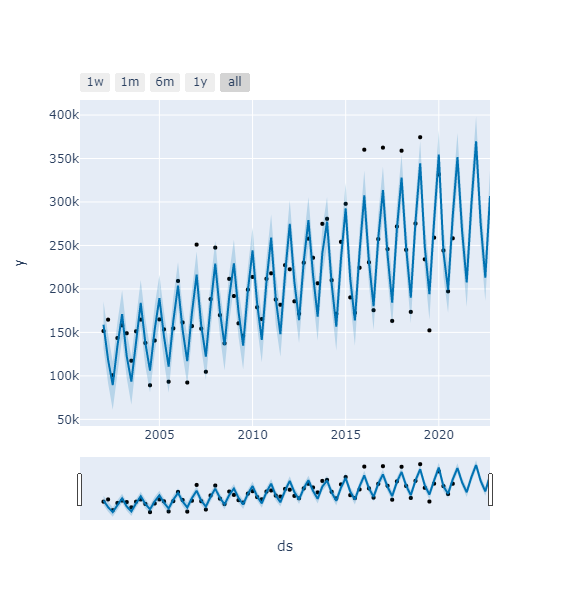

In [5]:
future = pron_isr.make_future_dataframe(periods=8)
future = future.merge(isr, on='ds')
fcst = pron_isr.predict(future)
py.init_notebook_mode()
fig=plot_plotly(pron_isr, fcst)
py.iplot(fig)

In [6]:
fig.write_html('ISR.html')

De hecho, se puede desagregar el pronóstico resultante de Prophet en sus componentes: tendencia, parte estacional y la parte correspondiente a las variables explícativas:

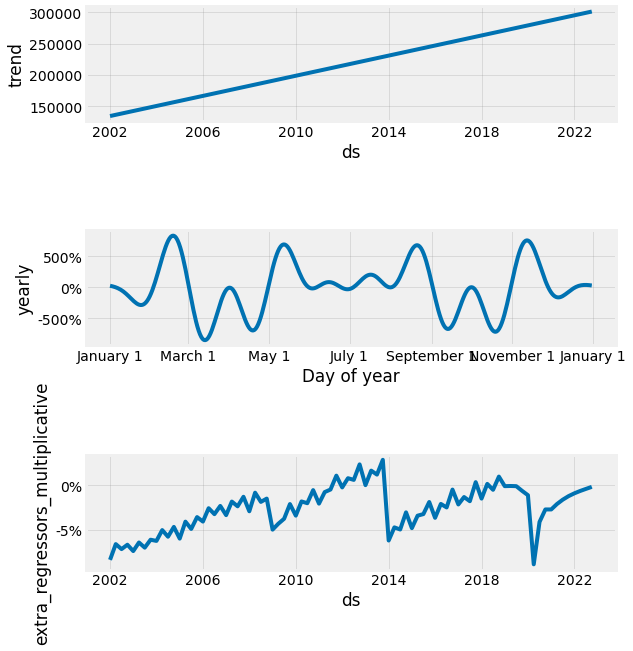

In [7]:
fig=pron_isr.plot_components(fcst)

In [8]:
fcst.to_csv('prophet_isr.csv')

### 3.2 Impuesto al Valor Agregado, IVA

In [9]:
iva=df[['fecha','iva_real','pib_reale4','tasa iva','covid']]
#isr=isrp.dropna()
iva.dtypes
iva.columns=['ds','y','pib','tasa iva','covid']
iva.tail(8)

ds   y          pib  tasa iva  covid
fecha                                                  
2021-01-01 2021-01-01 NaN  4384275.874        16      0
2021-04-01 2021-04-01 NaN  4443944.620        16      0
2021-07-01 2021-07-01 NaN  4492138.607        16      0
2021-10-01 2021-10-01 NaN  4531611.778        16      0
2022-01-01 2022-01-01 NaN  4562823.122        16      0
2022-04-01 2022-04-01 NaN  4588526.582        16      0
2022-07-01 2022-07-01 NaN  4611476.100        16      0
2022-10-01 2022-10-01 NaN  4633966.627        16      0

In [10]:
pron_iva=Prophet(seasonality_mode='multiplicative') #,changepoints=['2010-01-01']
pron_iva.add_regressor('pib')
pron_iva.add_regressor('tasa iva')
#pron_iva.add_regressor('covid')
pron_iva.fit(iva)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


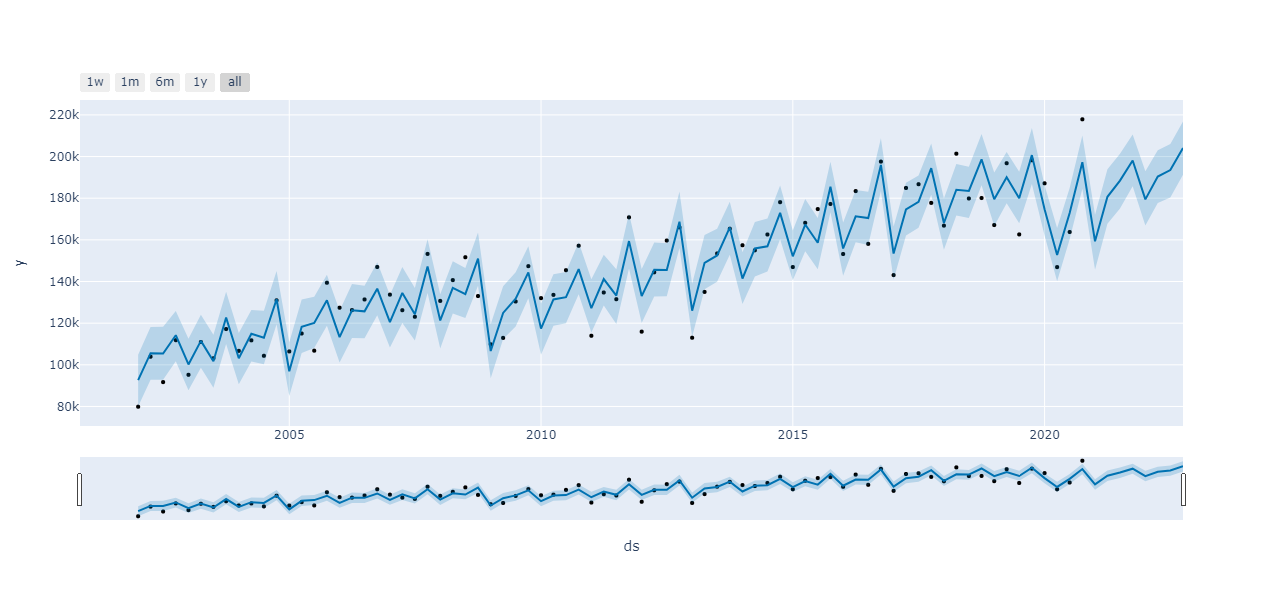

In [11]:
future = pron_iva.make_future_dataframe(periods=8)
future = future.merge(iva, on='ds')
fcst = pron_iva.predict(future)
fig=plot_plotly(pron_iva, fcst)
py.iplot(fig)

In [12]:
fig.write_html('IVA.html')

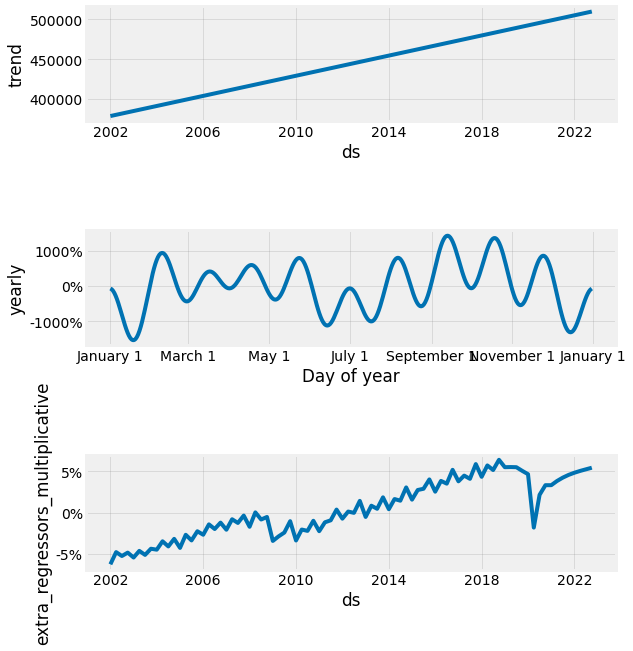

In [13]:
fig=pron_iva.plot_components(fcst)

In [14]:
fcst.to_csv('prophet_iva.csv')

## 4. Análisis de las Series Mensuales

Solo dejaré comentarios para la serie de IEPS Cervezas. El resto de las series mensuales no tienen comentarios.

### 4.1 IEPS Cervezas

Para utilizar Prophet en las series mensuales, solo tuve que indicar que la estacionalidad es multiplicativa. El resto del análisis que realiza Prophet es completamente automático y en cada serie hice lo mismo. Aquí el pronóstico de IEPS Cervezas:

In [15]:
df = pd.read_csv('202103mensuales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia  fechas  ieps_gasolinas  ieps_tabacos  \
fecha                                                              
2022-08-01  2022    8    1  ago-22             NaN           NaN   
2022-09-01  2022    9    1  sep-22             NaN           NaN   
2022-10-01  2022   10    1  oct-22             NaN           NaN   
2022-11-01  2022   11    1  nov-22             NaN           NaN   
2022-12-01  2022   12    1  dic-22             NaN           NaN   

            ieps_bebidas  ieps_cervezas  rfp_petroleros      fecha  
fecha                                                               
2022-08-01           NaN            NaN             NaN 2022-08-01  
2022-09-01           NaN            NaN             NaN 2022-09-01  
2022-10-01           NaN            NaN             NaN 2022-10-01  
2022-11-01           NaN            NaN             NaN 2022-11-01  
2022-12-01           NaN            NaN             NaN 2022-12-01

In [16]:
iepsc2=df[['fecha','ieps_cervezas']]
iepsc=iepsc2.dropna()
iepsc.columns=['ds','y']
iepsc.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


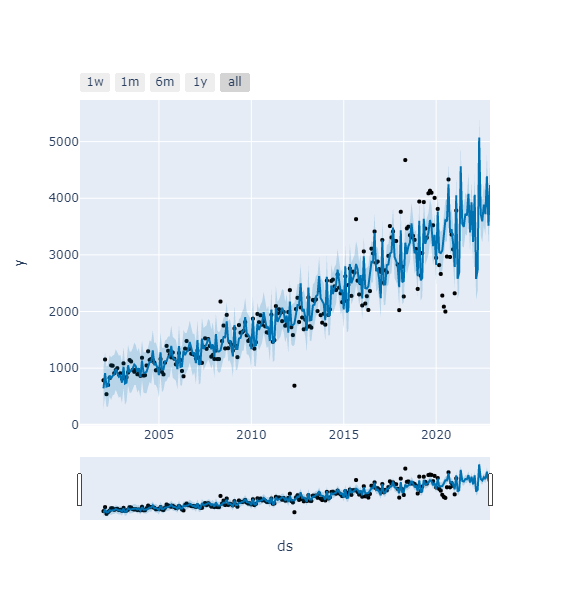

In [17]:
proniepsc=Prophet(seasonality_mode='multiplicative').fit(iepsc)
future = proniepsc.make_future_dataframe(periods=22, freq='M')
fcst = proniepsc.predict(future)
fig=plot_plotly(proniepsc, fcst)
py.iplot(fig)

In [18]:
fig.write_html('IEPS_C.html')

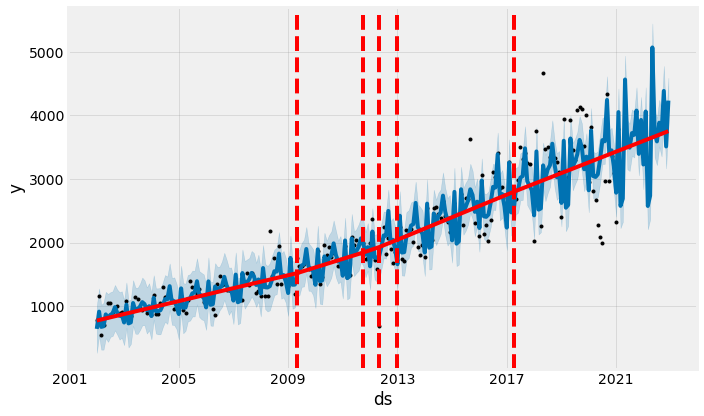

In [19]:
fig=proniepsc.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsc,fcst)

In [20]:
fcst.to_csv('prophet_iepsc.csv')

### 4.2 IEPS Bebidas

In [21]:
iepsb2=df[['fecha','ieps_bebidas']]
iepsb=iepsb2.dropna()
iepsb.columns=['ds','y']
iepsb.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


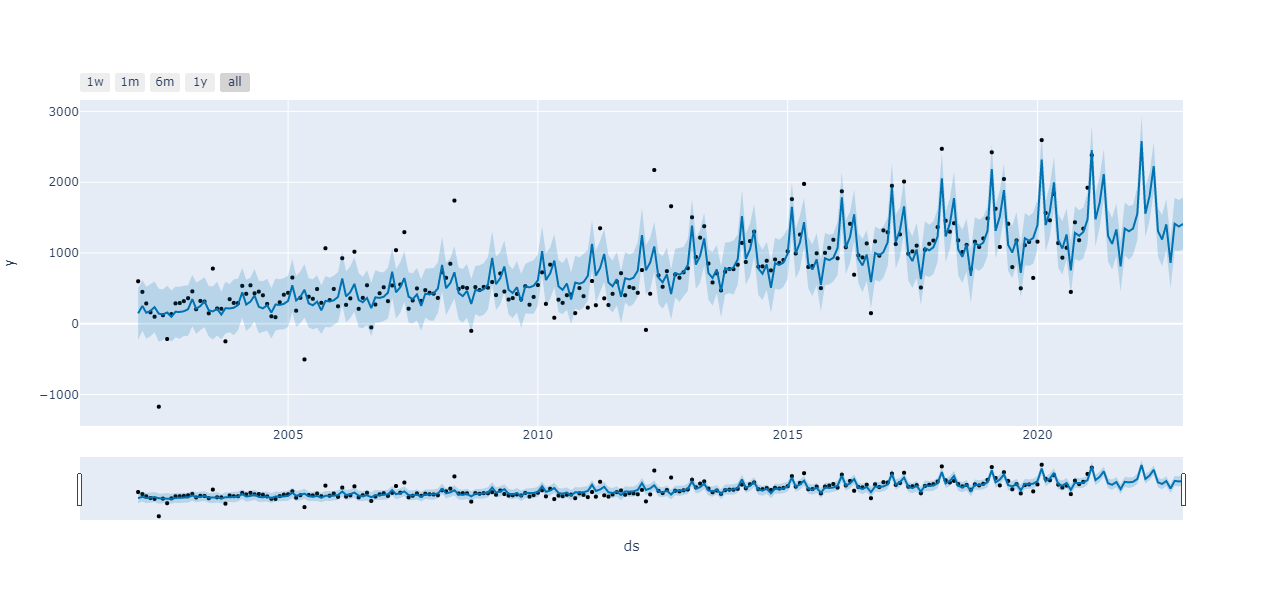

In [22]:
proniepsb=Prophet(seasonality_mode='multiplicative').fit(iepsb)
future = proniepsb.make_future_dataframe(periods=22, freq='M')
fcst = proniepsb.predict(future)
fig=plot_plotly(proniepsb, fcst)
py.iplot(fig)

In [23]:
fig.write_html('IEPS_B.html')

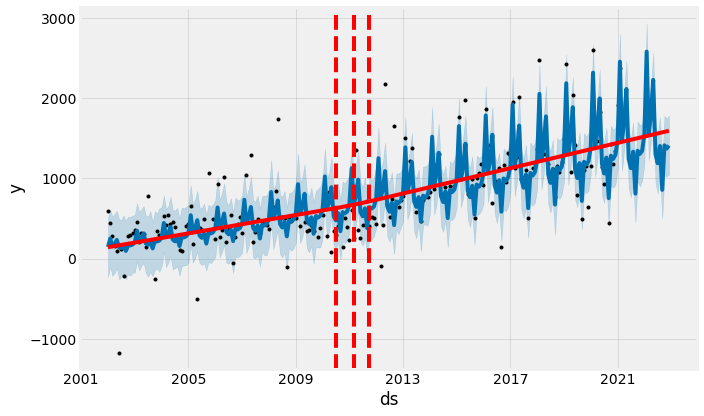

In [24]:
fig=proniepsb.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsb,fcst)

In [25]:
fcst.to_csv('prophet_iepsb.csv')

### 4.3 IEPS Tabacos

In [26]:
iepst2=df[['fecha','ieps_tabacos']]
iepst=iepst2.dropna()
iepst.columns=['ds','y']
iepst.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


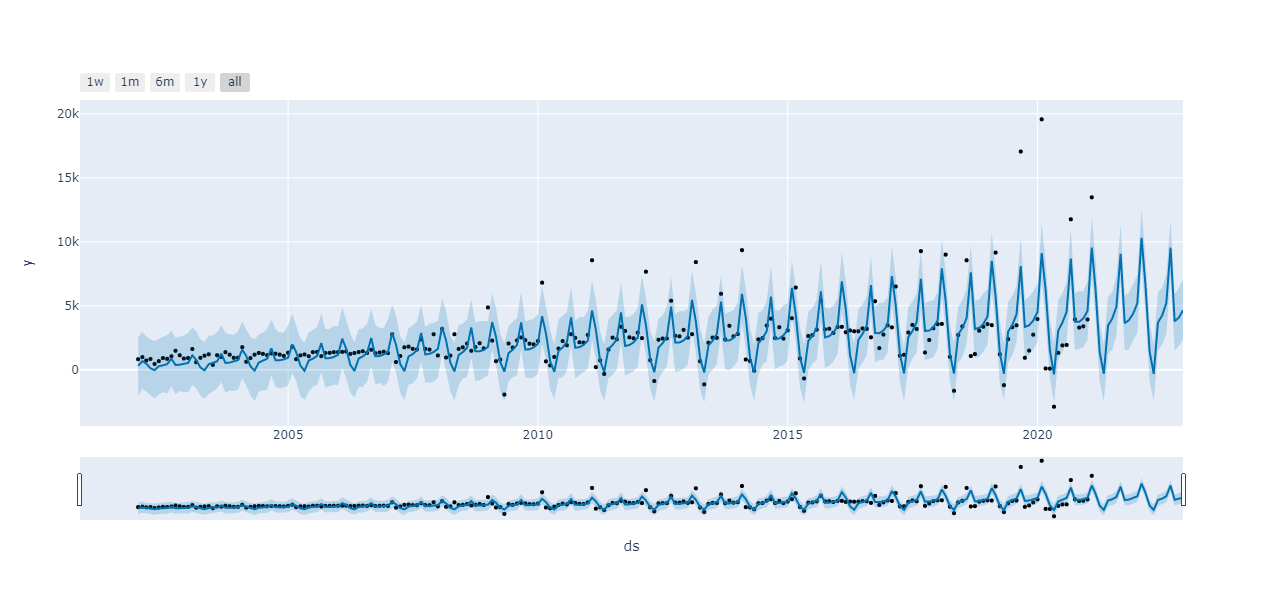

In [27]:
proniepst=Prophet(seasonality_mode='multiplicative').fit(iepst)
future = proniepst.make_future_dataframe(periods=22, freq='M')
fcst = proniepst.predict(future)
fig=plot_plotly(proniepst, fcst)
py.iplot(fig)

In [28]:
fig.write_html('IEPS_T.html')

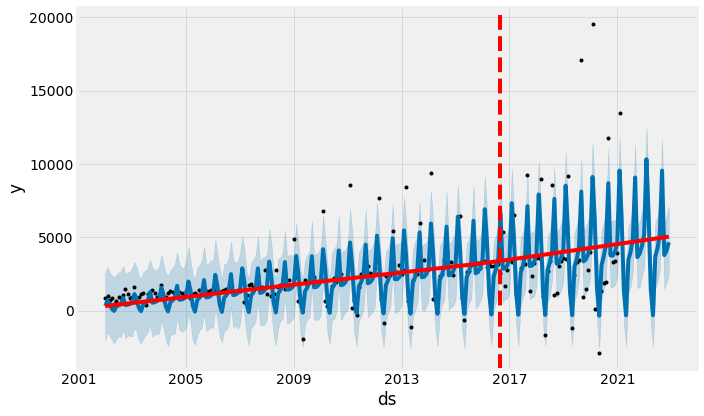

In [29]:
fig=proniepst.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepst,fcst)

In [30]:
fcst.to_csv('prophet_iepst.csv')

### 4.4 IEPS Gasolinas y Diésel

In [31]:
iepsg2=df[['fecha','ieps_gasolinas']]
iepsg=iepsg2.dropna()
iepsg.columns=['ds','y']
iepsg.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


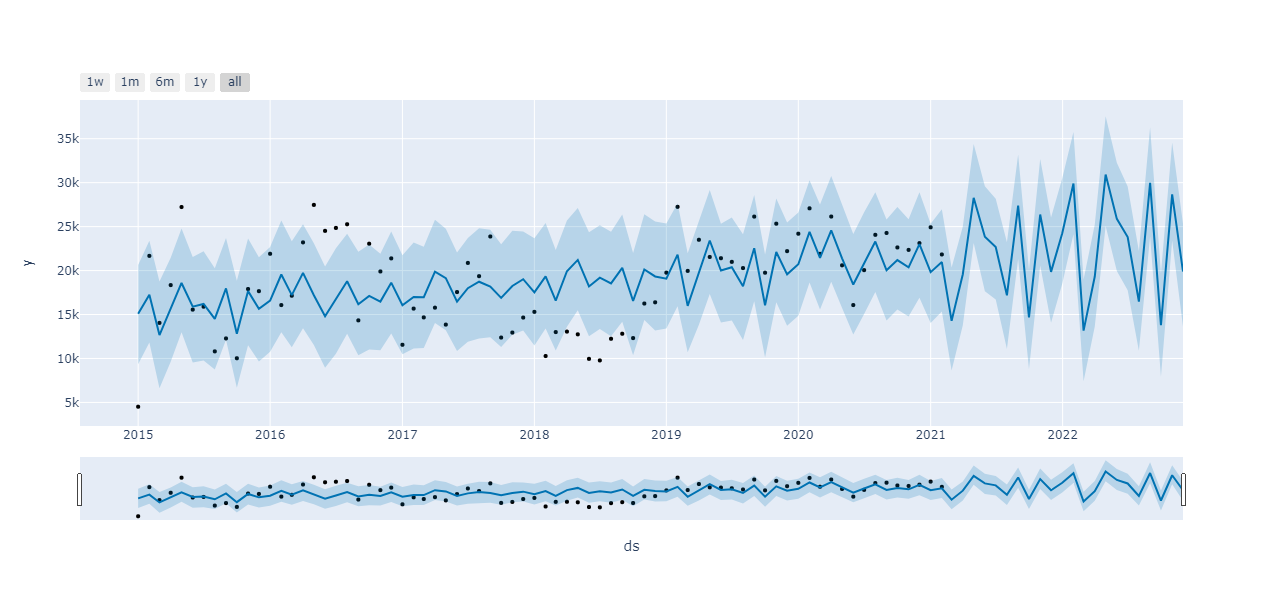

In [32]:
proniepsg=Prophet(seasonality_mode='multiplicative').fit(iepsg)
future = proniepsg.make_future_dataframe(periods=22, freq='M')
fcst = proniepsg.predict(future)
fig=plot_plotly(proniepsg, fcst)
py.iplot(fig)

In [33]:
fig.write_html('IEPS_G.html')

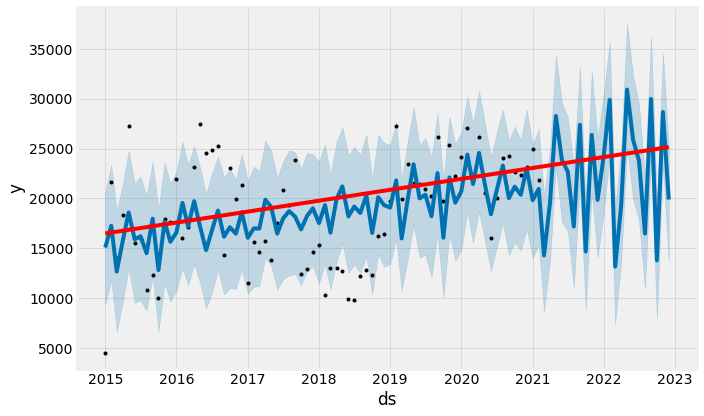

In [34]:
fig=proniepsg.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsg,fcst)

In [35]:
fcst.to_csv('prophet_iepsg.csv')

### 4.5 Ingresos Petroleros

In [36]:
petr2=df[['fecha','rfp_petroleros']]
petr=petr2.dropna()
petr.columns=['ds','y']
petr.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


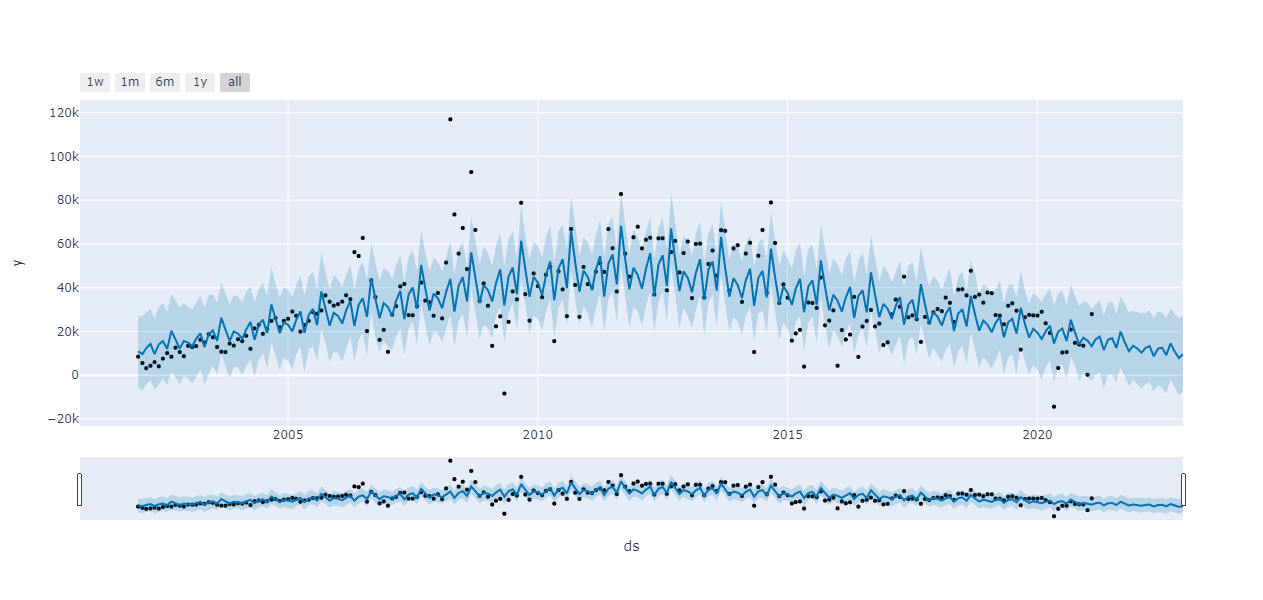

In [37]:
pronpetr=Prophet(seasonality_mode='multiplicative').fit(petr)
future = pronpetr.make_future_dataframe(periods=22, freq='M')
fcst = pronpetr.predict(future)
fig=plot_plotly(pronpetr, fcst)
py.iplot(fig)

In [38]:
fig.write_html('Petroleros.html')

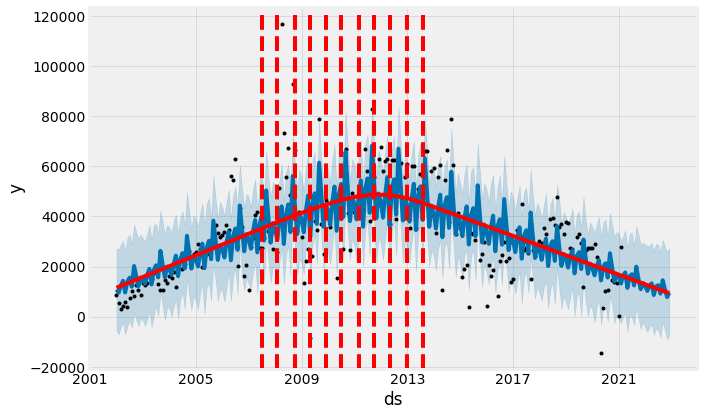

In [39]:
fig=pronpetr.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),pronpetr,fcst)

In [40]:
fcst.to_csv('prophet_petr.csv')

### 5. Conclusiones

Para ver las conclusiones sugiero revisar el respectivo blog [aquí](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/)